# Figures for paper

In [1]:
# Import modules and R
import numpy as np, pandas as pd
import pickle
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [149]:
# Import local code
import sys
sys.path.append('../code')
import pcaVersion
from processing_helpers import *
from analysis_helpers import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

## 1 — PC brains

In [164]:
data_dir = "~/rds/rds-cam-psych-transc-Pb9UGUlrwWc/Cam_LIBD/AHBA_data/abagen-data/expression/"
hcp_base = pcaVersion(pd.read_csv(data_dir + 'hcp_base.csv', index_col=0))
hcp_3donors_ds8 = pcaVersion(pd.read_csv(data_dir + 'hcp_3donors_ds8.csv', index_col=0))

New PCA version
New PCA version


In [11]:
ahba_scores = (pd.concat({
    'No filters': hcp_base.scores,
    'Both region & gene filters': hcp_base.score_from(hcp_3donors_ds8),
})
          .groupby(level=0)
          .apply(lambda x: (x-np.mean(x))/np.std(x))
          .reset_index(level=0).rename({'level_0':'version'},axis=1)
          .join(get_labels_hcp())
         )

## 1 — Triplets filtering

In [16]:
triplets_hcp = load_pickle('triplets_hcp')
triplets_hcp_3donors = load_pickle('triplets_hcp_3donors')
triplets_hcp_ds8 = filter_triplet_ds(triplets_hcp, ds_threshold=0.8)
triplets_hcp_3donors_ds8 = filter_triplet_ds(triplets_hcp_3donors, ds_threshold=0.8)

In [122]:
coefs_dict = {
    'No filters': disjoint_corrs(triplets_hcp),
    'Region filter \n(3+ donors)': disjoint_corrs(triplets_hcp_3donors),
    'Gene filter \n(top 20% diff. stab.)': disjoint_corrs(triplets_hcp_ds8),
    'Both region \n& gene filters': disjoint_corrs(triplets_hcp_3donors_ds8),
}

scores_dict = {
    'No filters': disjoint_corrs(triplets_hcp, how='scores'),
    'Region filter \n(3+ donors)': disjoint_corrs(triplets_hcp_3donors, how='scores'),
    'Gene filter \n(top 20% diff. stab.)': disjoint_corrs(triplets_hcp_ds8, how='scores'),
    'Both region \n& gene filters': disjoint_corrs(triplets_hcp_3donors_ds8, how='scores'),
}


triplet_versions = (
    pd.concat({'Gene weights':pd.concat(coefs_dict), 'Region scores':pd.concat(scores_dict)})
    .reset_index()
    .rename(columns={'level_0':'how', 'level_1':'version', 'level_2':'component'})
    .assign(component=lambda x: x['component'].replace({i:f'{i+1}' for i in range(5)}))
    .melt(id_vars=['how', 'version', 'component'], var_name='pair', value_name='corr')
    .assign(corr_abs = lambda x: np.abs(x['corr']))
    .assign(version = lambda x: pd.Categorical(x['version'], categories=x['version'].unique(),ordered=True))
)

## 1 — Distributions

In [25]:
# expression_hcp, _, counts_hcp, stability = get_expression_abagen(atlas=fetch_hcp(native=False), return_labels=True, return_counts=True, return_stability=True)

15947 genes remain after filtering for top 1 differential stability


In [109]:
# counts_hcp.to_csv("../outputs/counts_hcp.csv")
# stability.to_csv("../outputs/stability.csv")
# counts_hcp = pd.read_csv("../outputs/counts_hcp.csv")
stability = pd.read_csv("../outputs/stability.csv", index_col=0).set_axis(['DS'], axis=1)
donor_counts = (counts_hcp!=0).sum(axis=1)[:180].rename('count').to_frame()

## 1 — Gene weight vs DS

In [60]:
coefs_ds = (hcp_3donors_ds8.coefs.T
            .iloc[:,:3].set_axis(['PC1','PC2','PC3'],axis=1)
            .join(stability))

## 1 — Brainspan PCA

In [128]:
cortex_scores = pd.read_csv('../outputs/cortex_scores_combined.csv')
bs_corrs = cortex_scores_combined.groupby('PC').apply(lambda x: x.corr()).loc[(slice(None), 'AHBA_mean'), 'Brainspan'].values

## 1 — Brainspan mapping

In [191]:
hcp_bs_mapping = pd.read_csv('../outputs/hcp_bs_mapping.csv', index_col=0)

In [175]:
bs_ahba_corr = pd.read_csv("../outputs/bs_ahba_corr.csv")

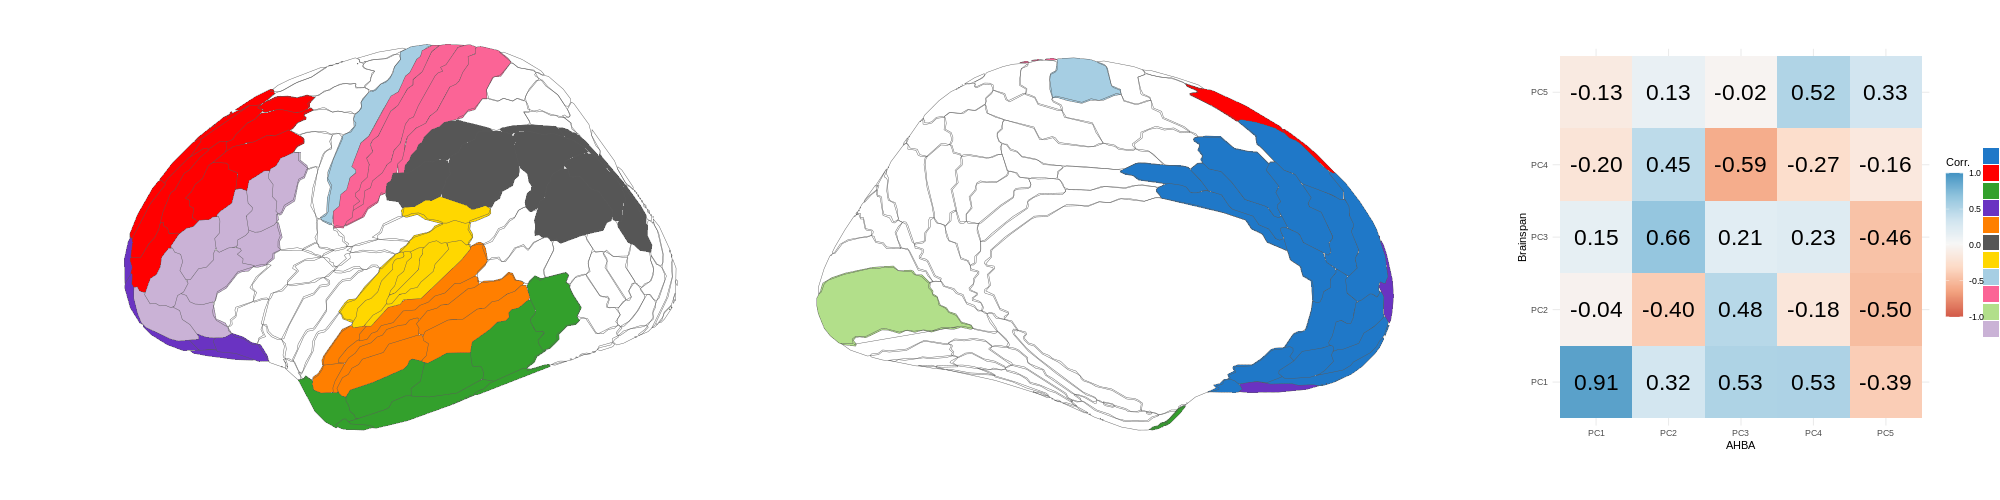

In [192]:
%%R -i hcp_bs_mapping -i bs_ahba_corr -w 2000 -h 500
source("../code/brainspanPlots.R")
g5 <- plot_bs_mapping(hcp_bs_mapping)
g6 <- plot_ahba_bs_corr(bs_ahba_corr)
(g5 | g6) + plot_layout(widths=c(4,1))

# 1 — Var explained

In [222]:
hcp_base.var_pct

array([0.1876432 , 0.10067362, 0.09006554, 0.06852596, 0.05254298])

In [223]:
hcp_3donors_ds8.var_pct

array([0.48161994, 0.10763054, 0.08151609, 0.03708704, 0.02723278])

# Fig 1

Message: With careful processing, PC2 and PC3 of the AHBA are robust and generalizable.

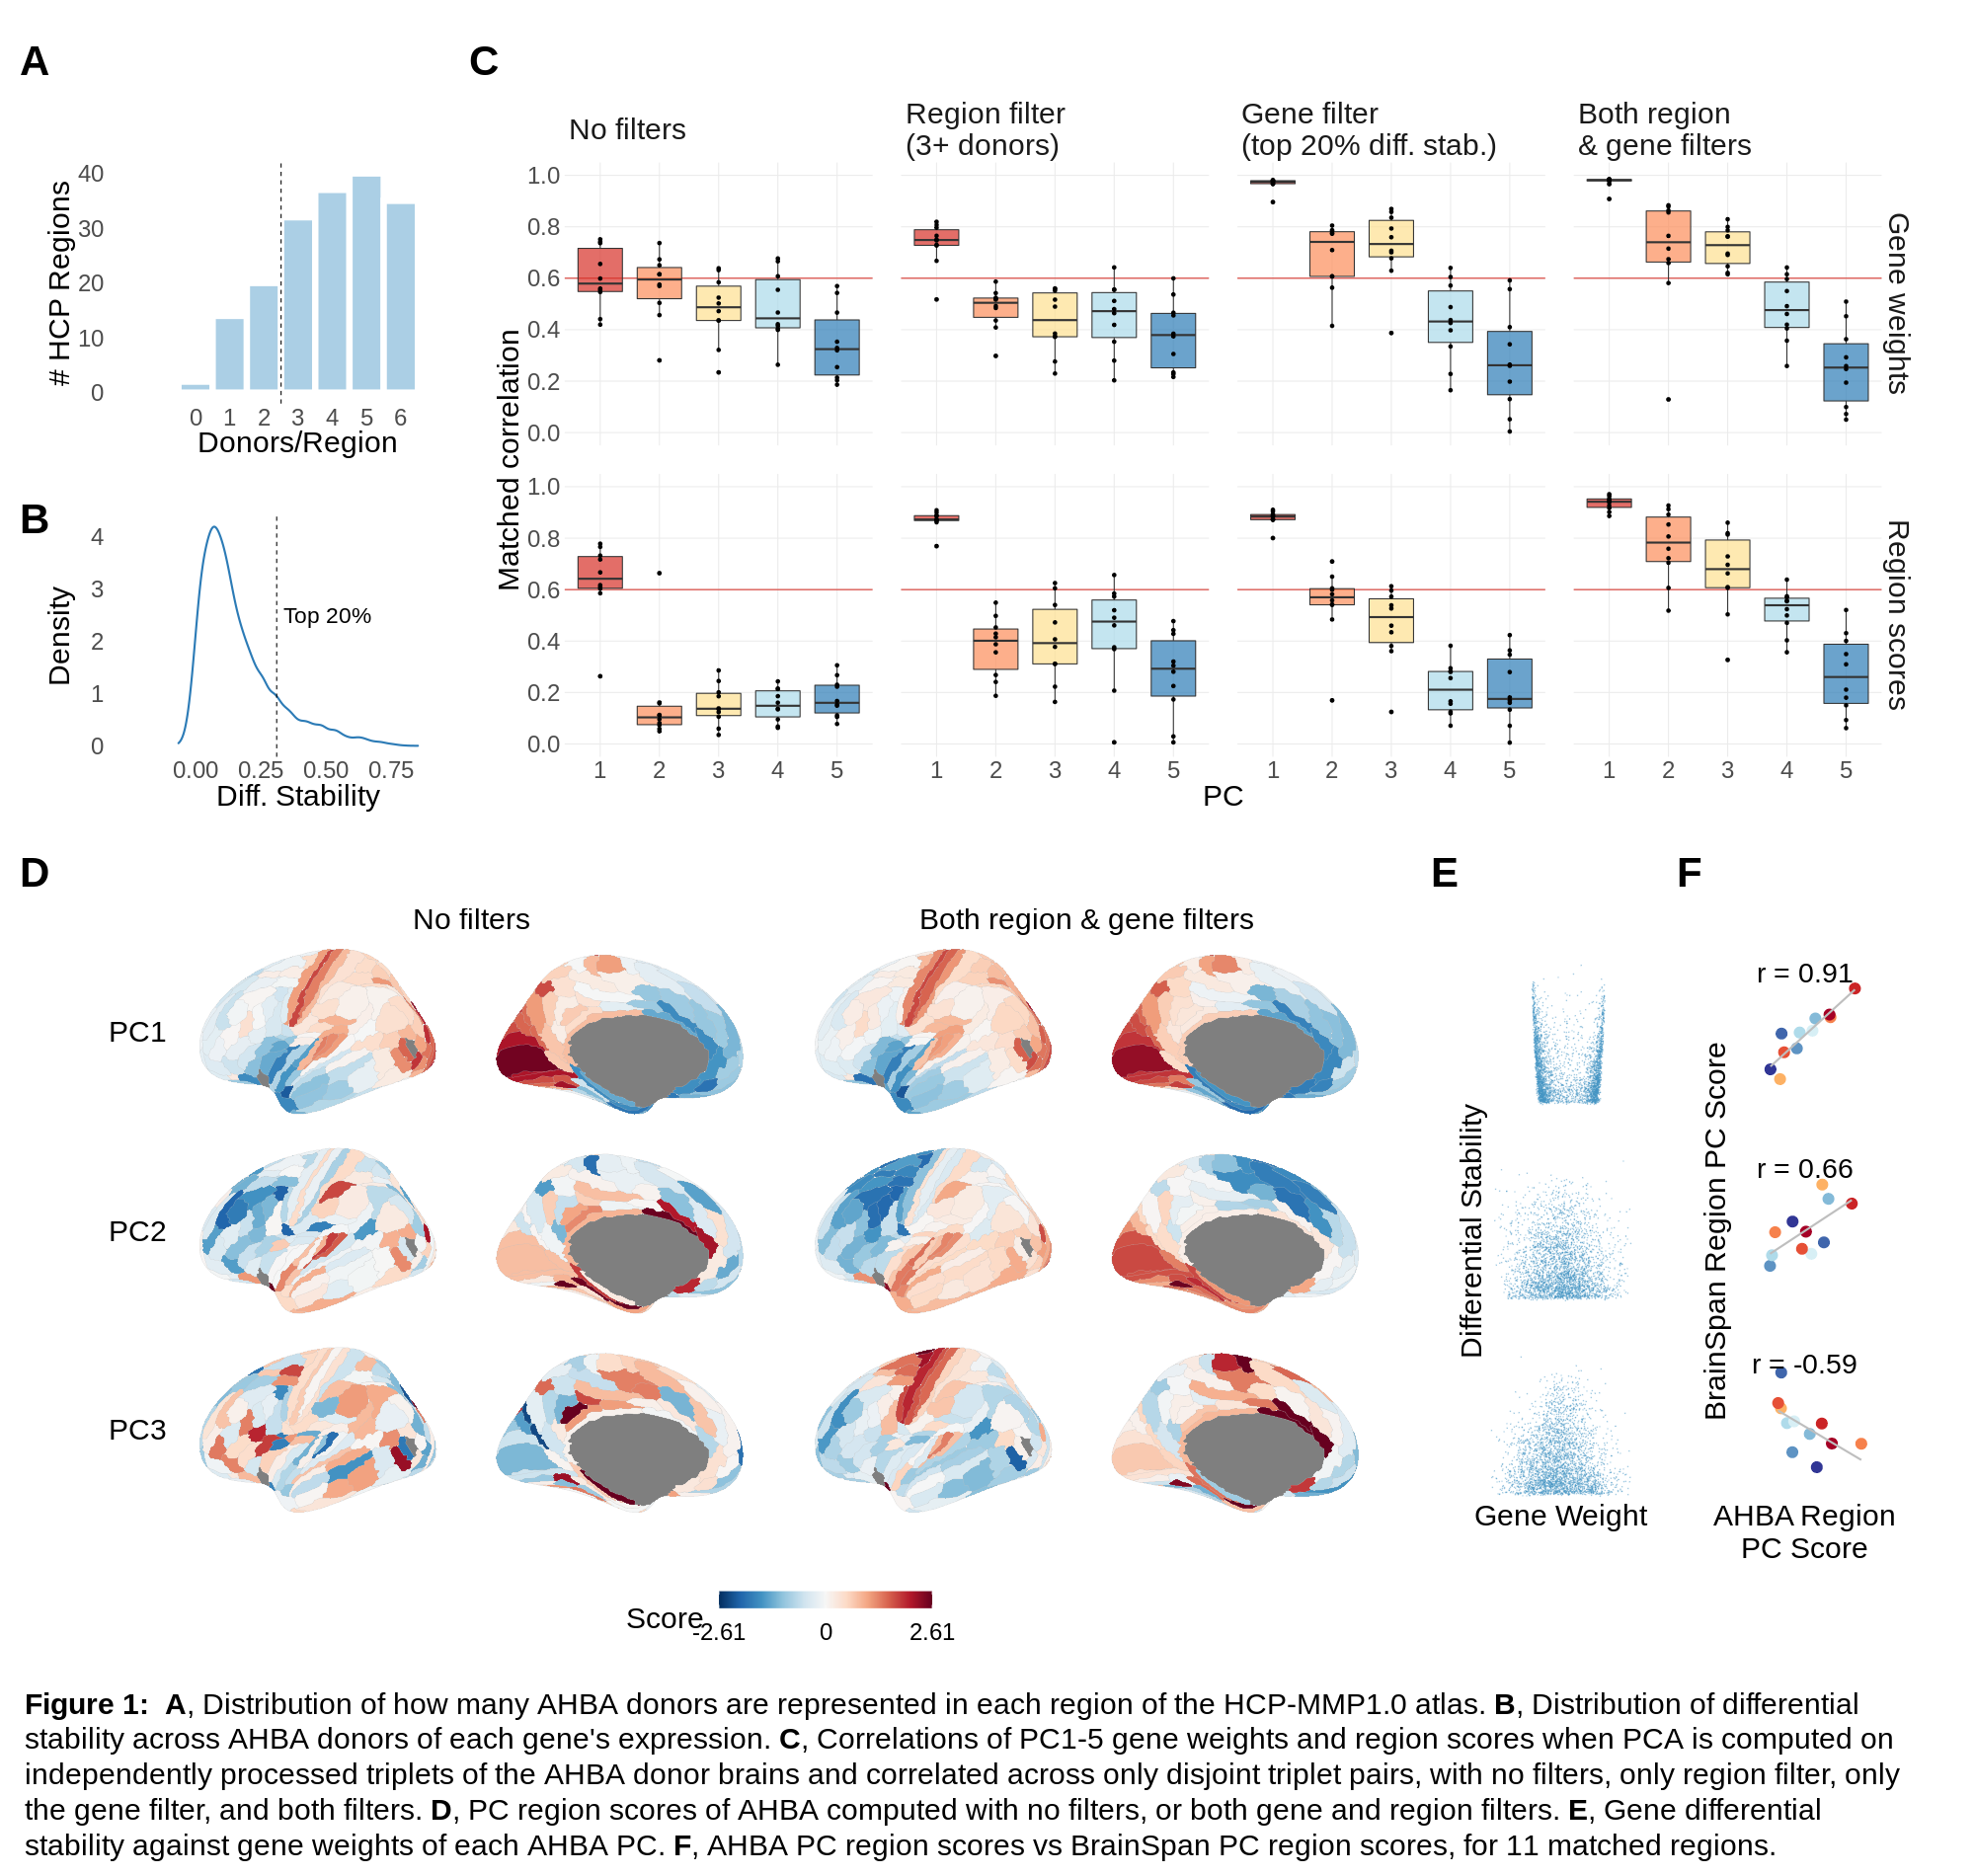

In [208]:
%%R -w 2000 -h 1900 -i ahba_scores -i triplet_versions -i donor_counts -i stability -i coefs_ds -i hcp_bs_mapping -i bs_ahba_corr
source("../code/Rplots.R")
source("../code/brainspanPlots.R")

g0 <- plot_hcp(ahba_scores, three=T, switch='y') + guides(fill=guide_colorbar(title='Score',barwidth=15))
g1a <- plot_dist_donors_hcp(donor_counts)
g1b <- plot_ds_dist_hcp(df_stability)
g2 <- plot_triplets(triplet_versions) 
g3 <- plot_coefs_ds(coefs_ds, facet='v')
g4 <- plot_ahba_bs_scatter(cortex_scores, bs_corrs, facet='v')
# g5 <- plot_ahba_bs_corr(bs_ahba_corr)
# g6 <- plot_bs_mapping(hcp_bs_mapping)


caption <- paste("**Figure 1:**",
                "**A**, Distribution of how many AHBA donors are represented in each region of the HCP-MMP1.0 atlas.",
                "**B**, Distribution of differential stability across AHBA donors of each gene's expression.",
                "**C**, Correlations of PC1-5 gene weights and region scores when PCA is computed on independently processed triplets of the AHBA donor brains and correlated across only disjoint triplet pairs, with no filters, only region filter, only the gene filter, and both filters.",
                "**D**, PC region scores of AHBA computed with no filters, or both gene and region filters.",
                "**E**, Gene differential stability against gene weights of each AHBA PC.",
                "**F**, AHBA PC region scores vs BrainSpan PC region scores, for 11 matched regions."
)


plot <- (
        # First row
        (((g1a / g1b) | g2) + plot_layout(widths=c(1,5))) /
        # Second row
        ((g0 | g3 | g4) + plot_layout(widths=c(8,1,1))) #/
        # Third row
        # ((g5 | g6 | plot_spacer()) + plot_layout(widths=c(1,2,1)))
    ) + plot_layout(heights=c(2,2)) 

themed <- plot & theme(
    text=element_text(size=30), 
    strip.text=element_text(size=30),
    plot.margin = margin(t=10, r=30, b=10, l=10, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)
    
annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

Add thin bottom row: var explained, Brainspan HCP matching, Brainspan correlation matrix 

## 2 — Development

In [214]:
bs_development = pd.read_csv("../outputs/bs_development.csv", index_col=0)

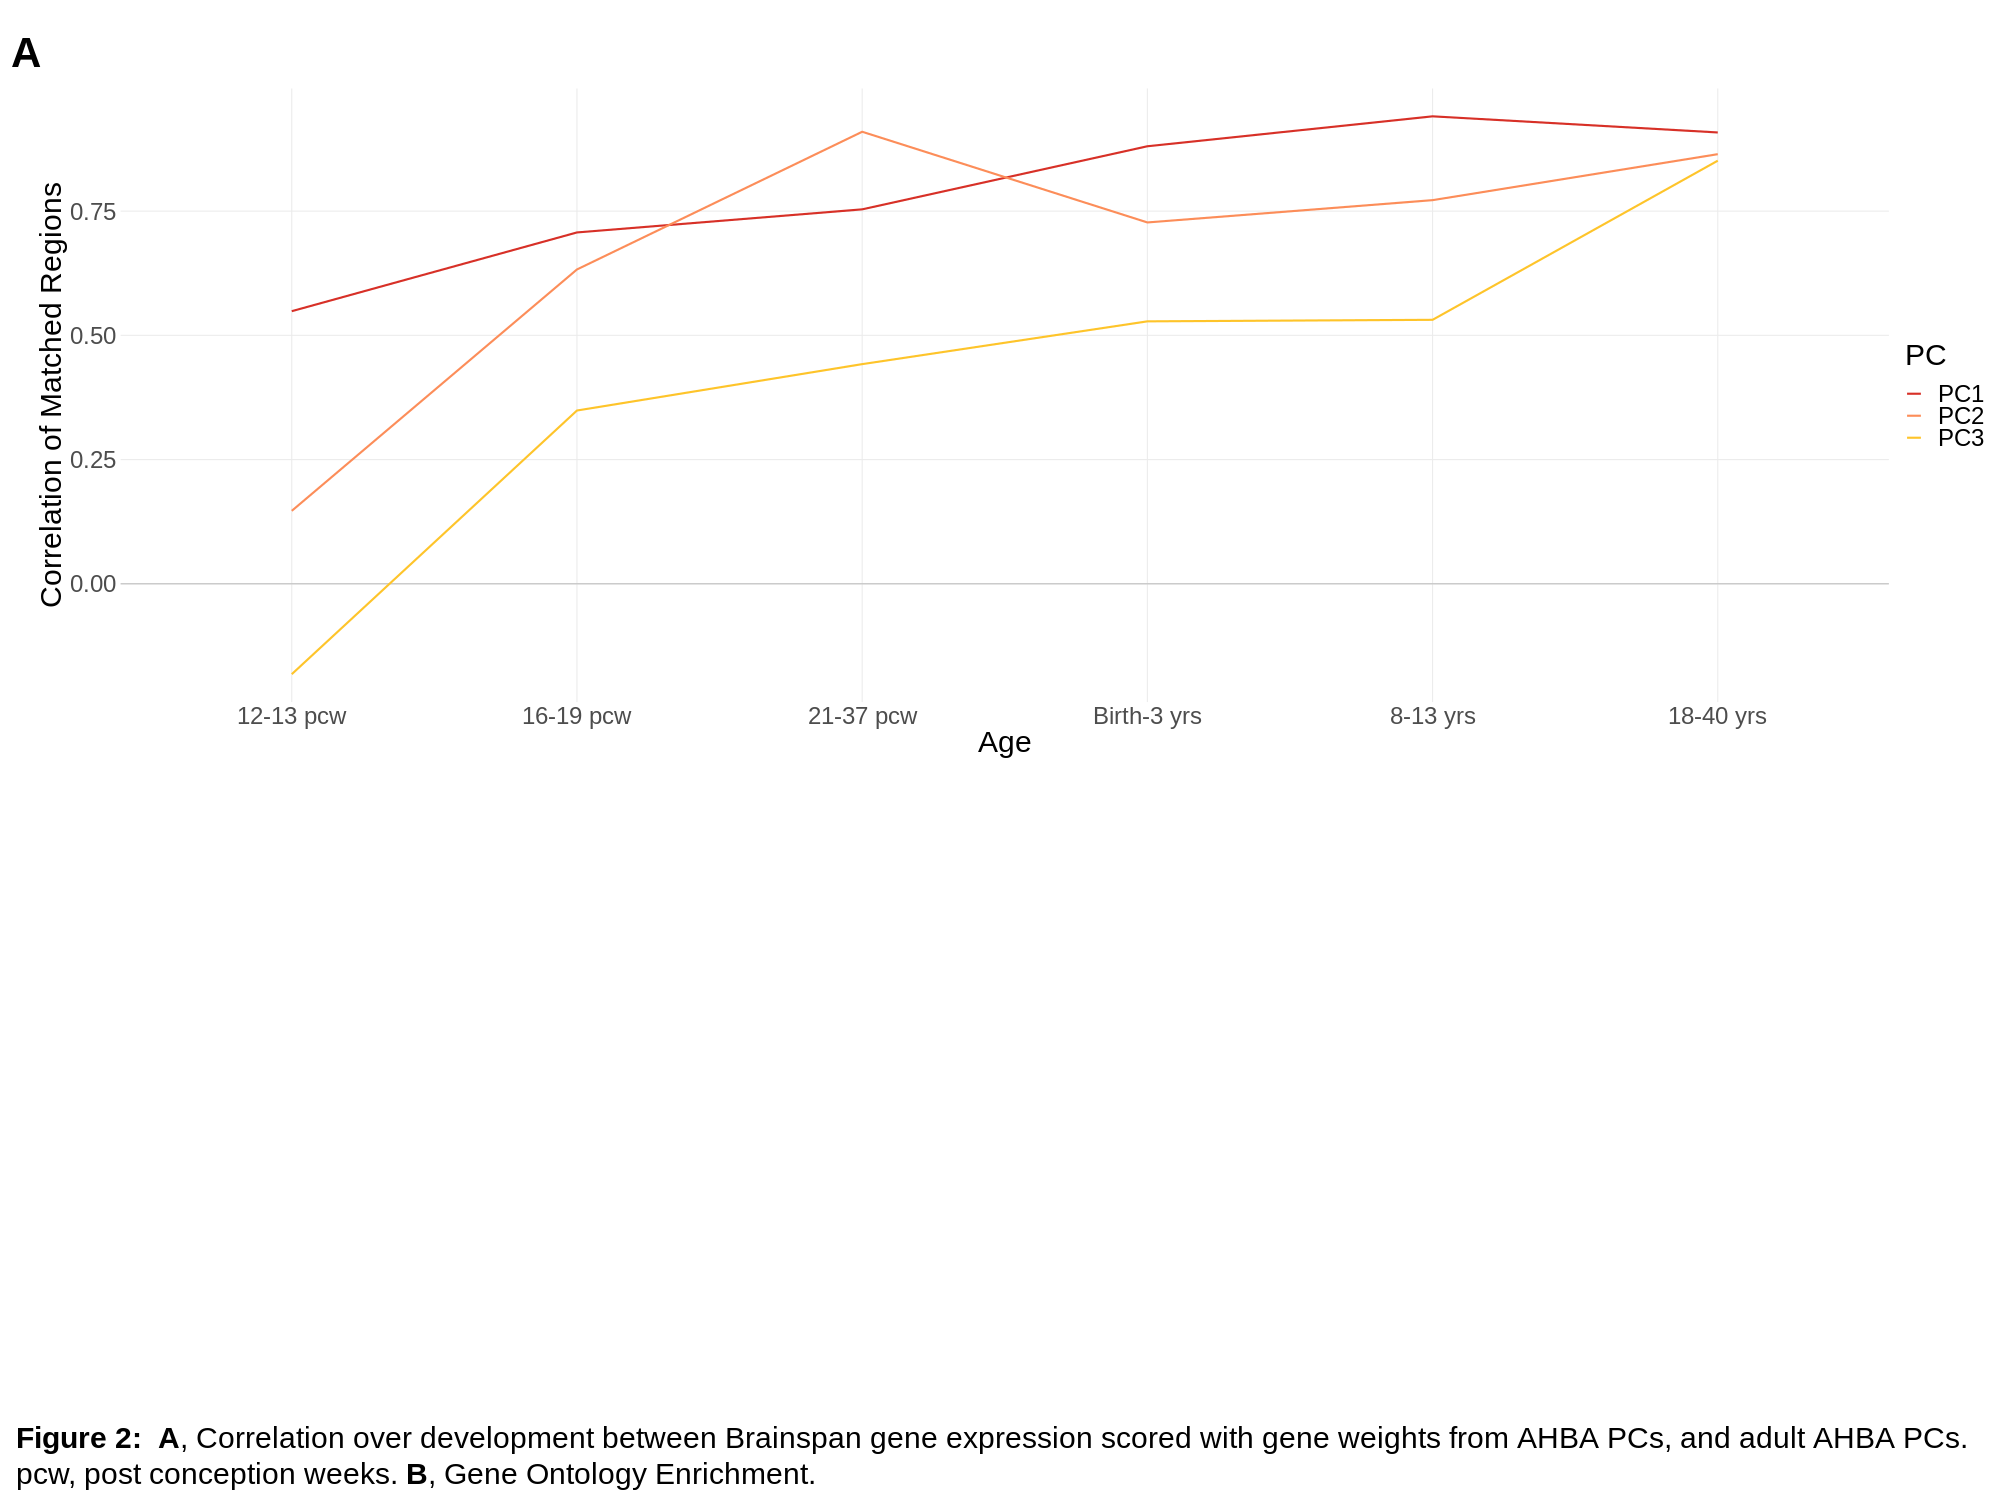

In [237]:
%%R -w 2000 -h 1500 -i bs_development
source("../code/brainspanPlots.R")

plot <- plot_bs_pcs_corr(bs_development, rotate=F) / plot_spacer()

caption <- paste("**Figure 2:**",
                "**A**, Correlation over development between Brainspan gene expression scored with gene weights from AHBA PCs, and adult AHBA PCs. pcw, post conception weeks.",
                "**B**, Gene Ontology Enrichment.")

themed <- plot & theme(
    text=element_text(size=30), 
    plot.tag = element_text(size=42, face='bold', vjust=-2))
annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

## 3 — Other maps

In [231]:
map_corrs_sig = pd.read_csv("../outputs/map_corrs_sig.csv", index_col=0)
scores_plot = pd.read_csv("../outputs/scores_plot.csv", index_col=0)
maps_plot = pd.read_csv("../outputs/maps_plot.csv", index_col=0)

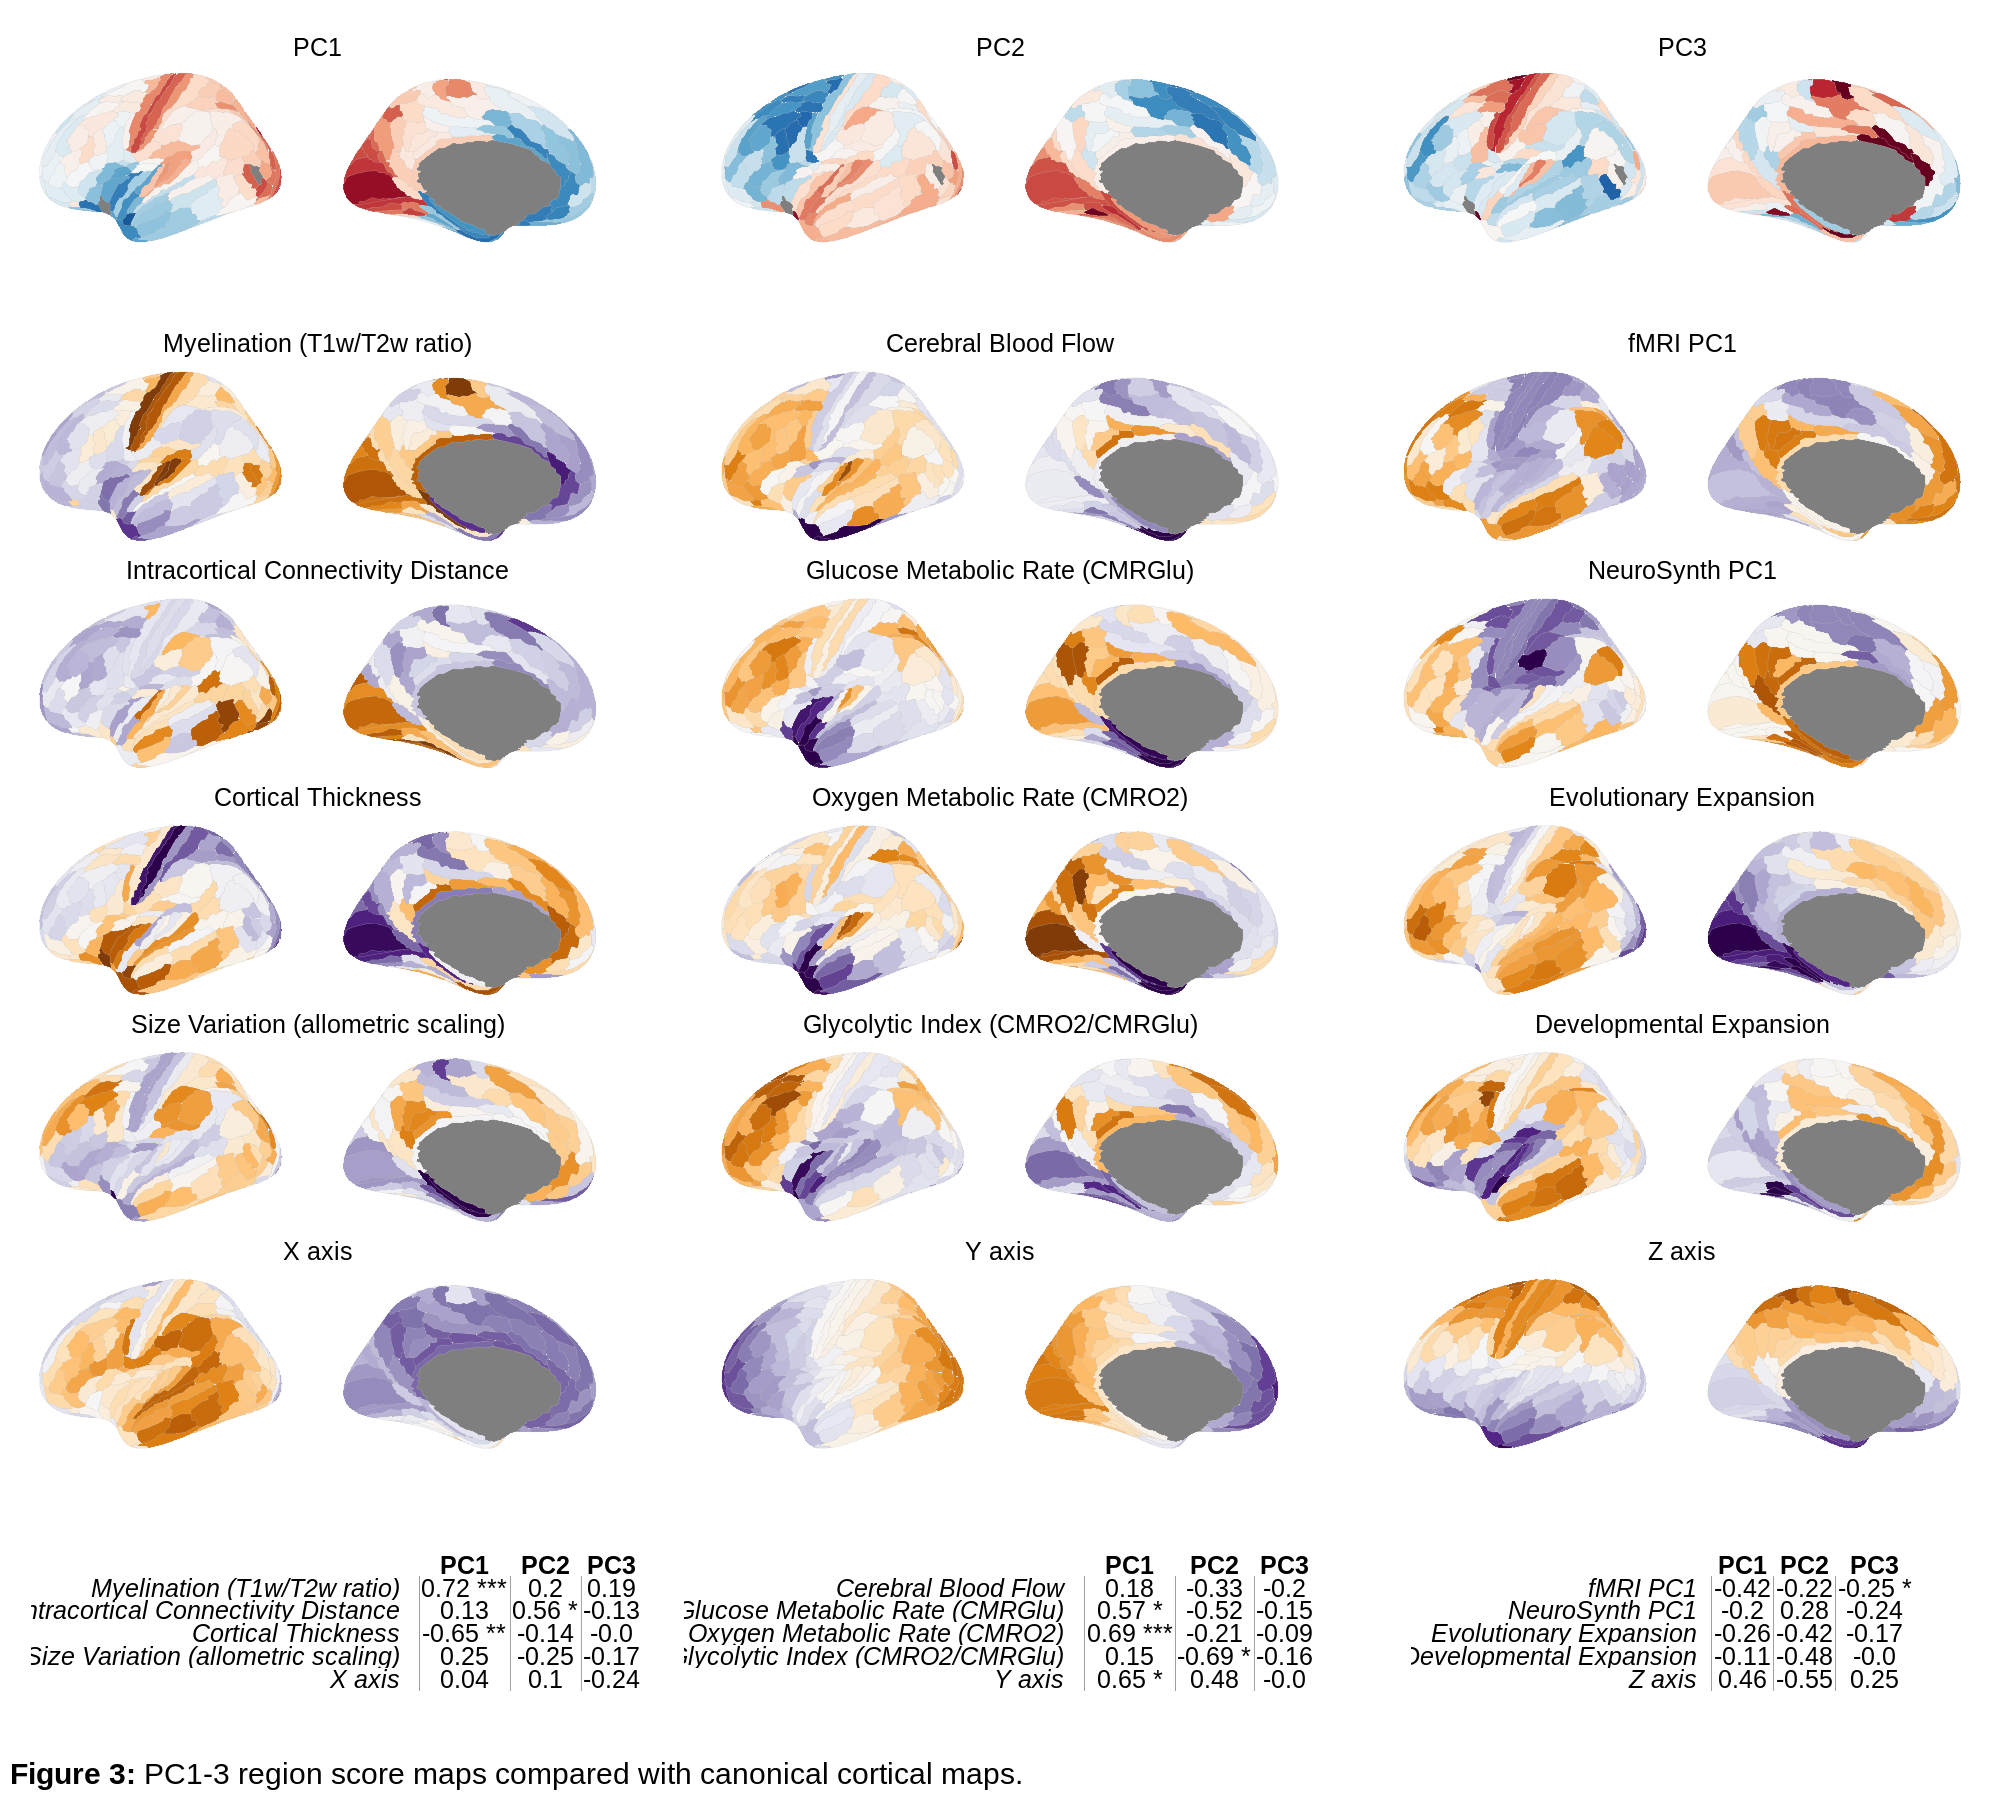

In [240]:
%%R -w 2000 -h 1800 -i maps_plot -i scores_plot -i map_corrs_sig
library(ggpubr)
g2 <- plot_hcp_wide(scores_plot) + guides(fill='none') + theme(strip.text.x = element_text(size=25))
g3 <- plot_maps(maps_plot, colors=rev(brewer.puor(100))) + guides(fill='none') + theme(strip.text.x = element_text(size=25))
gt1 <- ggtexttable(map_corrs_sig[1:5,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))
gt2 <- ggtexttable(map_corrs_sig[6:10,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))
gt3 <- ggtexttable(map_corrs_sig[11:15,], theme=ttheme('minimal', base_size=25, padding = unit(c(5, 5, 5, 5), "pt")))

caption <- paste("**Figure 3:**",
                 "PC1-3 region score maps compared with canonical cortical maps.")

plot <- (g2 / g3 / (gt1 | gt2 | gt3)) + plot_layout(heights=c(1,6,1)) 
themed <- plot #& theme(plot.tag = element_text(size=42, face='bold', vjust=-2))
annotated <- themed + plot_annotation(
  # tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated